In [15]:
library(repr)
options(repr.plot.width=6, repr.plot.height=5)

In [16]:
library(tidyverse)
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BSgenome.Hsapiens.UCSC.hg38)
library(pheatmap)
library(TFBSTools)
library(BiocParallel)
register(MulticoreParam(10))
set.seed(2019)

In [17]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/")

# chromVAR analysis 1 - chromVAR + Jaspar 2020 motifs
**Inputs**
1. *Peaks*: These are peaks centered at summit with uniform width of 500 bp as recommended by chromVAR. Files are under `/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap.bed`. First 3 columns are standard bed, the 4th column is peak intensity as calculated from MACS2.
2. *Annovation*: Jaspar 2020 motifs

In [24]:
samplesheet <- read.csv('samplesheet2.csv', stringsAsFactors = F)

# Peaks
peak.file <- "/c/groups/sanjana_lab/cdai/TFscreen/atac/diffbind/diffbind_consensu_min2overlap.bed"
peaks <- getPeaks(peak.file, sort_peaks = T)

Warning message in gzfile(file, mode):
“cannot open compressed file '/tmp/Rtmpx6vt0C/libloc_208_24a2b10a4b711cb5.rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, mode): cannot open the connection


In [5]:
peaks <- resize(peaks, width = 500, fix = "center")

my_counts_matrix <- read.table("diffbind/diffbind_consensu_min2overlap_readcounts.txt", header = T) %>% as.matrix

depth <- apply(my_counts_matrix, 2, sum)
colData <- column_to_rownames(samplesheet, 'SampleID')
colData <- add_column(colData, depth) # add read depth per sample

fragment_counts <- SummarizedExperiment(assays = list(counts = my_counts_matrix),
                                        rowRanges = peaks, colData = colData)

fragment_counts.addGC <- addGCBias(fragment_counts, genome = BSgenome.Hsapiens.UCSC.hg38)

# each peak must have at least 10 reads across all 12 samples to be included
fragment_counts.filtered <- filterPeaks(fragment_counts.addGC, min_fragments_per_peak = 10, 
                                       non_overlapping = T)

In [6]:
#make a grange object of normalized atac-seq counts
my_counts_matrix.norm <- apply(my_counts_matrix, MARGIN = 2, function(x) x * 1000000/sum(x))
my_counts_matrix.norm <- peaks %>% as.data.frame %>% cbind(my_counts_matrix.norm) %>% GenomicRanges::makeGRangesFromDataFrame(keep.extra.columns = T)

#### Annotations

Get JASPAR2020 motifs. Then construct a motif - gene_name lookup table. In addition, add columns to indicate if a motif is a TF or hit TF.

In [7]:
# New method: use downloaded JASPAR2020
jaspar_2020 <- readJASPARMatrix("JASPAR2020_combined_matrices_20191030.txt", matrixClass = "PFM")

#120 hit list
hitlist <- read.csv('/c/groups/sanjana_lab/cdai/TFscreen/Hitlist_20191230.csv', header = T, stringsAsFactors = F) %>% pull(hgnc_symbol)
#TF list
tflist <- read.csv('/c/groups/sanjana_lab/cdai/TFscreen/TFlist_20191230.csv', stringsAsFactors = F) %>% pull(hgnc_symbol)

In [8]:
# construct base motif_lookup table
motif_lookup <- TFBSTools::name(jaspar_2020) %>% 
                data.frame(stringsAsFactors = F) %>% 
                rownames_to_column("motif") %>% 
                mutate(gene_name=str_extract(`.`, "[a-zA-Z:0-9\\-]+")) %>%
                select(motif, gene_name)

# function to check if a tf name is in the substring of jaspar name
mystrfunc <- function(stringA, target) {
    # string A is a possible gene name, scalar
    # target is a vector of proper gene names
    # match if any target is a substring in string A, if so return True
    stringA <- rep(stringA, length(target))
    test <- unlist(map2(stringA, target, ~ str_detect(.x, .y)))
    return(any(test))
}

#motif_lookup <- motif_lookup  %>% mutate(is_hit = map(gene_name, ~ if_else(mystrfunc(.x, hitlist), "Yes", "No"))) %>%
                 #mutate(is_tf = map(gene_name, ~ if_else(mystrfunc(.x, tflist), "Yes", "No"))) 

is_hit <- map(motif_lookup$gene_name, ~ if_else(mystrfunc(.x, hitlist), "Yes", "No")) %>% unlist
is_tf <- map(motif_lookup$gene_name, ~ if_else(mystrfunc(.x, tflist), "Yes", "No")) %>% unlist

motif_lookup <- motif_lookup %>% add_column(is_hit = is_hit, is_tf = is_tf)

#### Deviations

In [9]:
# get motif matches with peaks
motif_ix <- matchMotifs(jaspar_2020, fragment_counts.filtered, genome = BSgenome.Hsapiens.UCSC.hg38)

In [10]:
# computing deviations
dev <- computeDeviations(object = fragment_counts.filtered, annotations = motif_ix)

In [11]:
# Add motif's gene names and whethere it's a hit / tf or not
# some motifs has 2 or 3 variants with the same gene name, thus taking the mean of all motif scores for the same gene
dev.scores <- deviationScores(dev) %>% 
                as.data.frame %>% 
                rownames_to_column('motif') %>% 
                left_join(motif_lookup, by = 'motif') %>%
                select(A1:is_tf) %>% 
                group_by(gene_name, is_hit, is_tf) %>% 
                summarise_all(mean) %>%
                ungroup()

In [12]:
dev.scores %>% filter(str_detect(gene_name, 'IN'))

gene_name,is_hit,is_tf,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HINFP,No,Yes,-0.5916762,-0.7901095,-0.2235681,-0.4417209,-0.3979235,0.4171578,-1.359658,0.2702368,0.5637700,-0.4490371,0.8219702,0.04021812
INSM1,Yes,Yes,-0.9283409,-0.6525645,-0.7188329,-0.3463750,0.5634787,-0.6455420,-0.680440,-0.1038145,0.6116756,-0.6608826,0.6284547,0.63420414


In [18]:
getwd()

[1] "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac"

---

## Hit TF motifs' accessibility

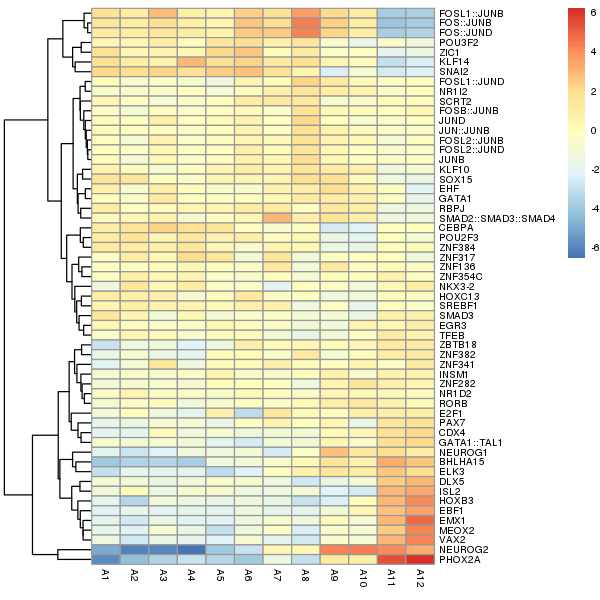

In [17]:
options(repr.plot.width=5, repr.plot.height=5)
dev.scores %>% filter(is_hit == "Yes") %>% 
                select(gene_name, A1:A12) %>% arrange(gene_name) %>%
                column_to_rownames('gene_name')  %>%
                pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, fontsize=6)

##### Heatmap for all TF (~1800) motif binding sites accessibility 

** cluster rows (TF motifs) by hits vs non hits **

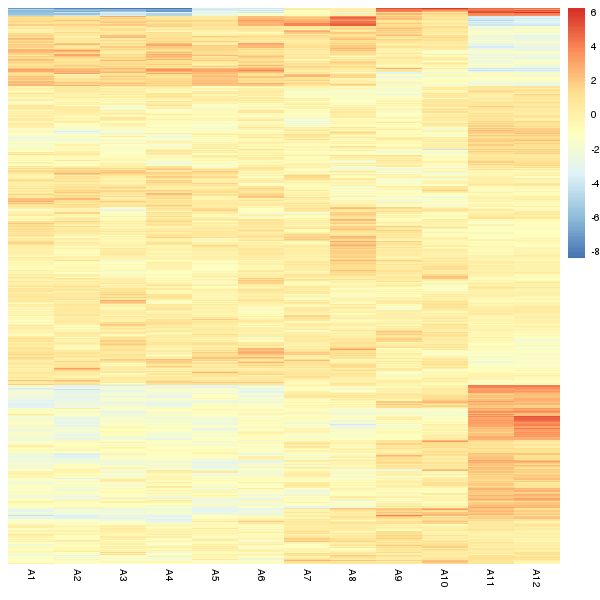

In [12]:
dev.scores %>%  filter(is_tf == "Yes") %>% select(gene_name, A1:A12)  %>% column_to_rownames('gene_name')  %>%
                        pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, show_colnames=T, fontsize=6, treeheight_row=0)

In [13]:
dev.scores %>% head

gene_name,is_hit,is_tf,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALX3,No,Yes,-1.6384447,-2.8446575,-1.8827820,-2.0961426,-2.4567807,-1.8130310,0.019649268,0.45831325,0.11274948,0.4392262,2.0574681,2.4345177
AR,No,Yes,-1.8444513,-1.2043915,-1.3958242,-1.4052146,-1.0476070,-0.7026961,0.996668890,-0.08521765,1.58243067,1.4792939,0.9980039,0.1986967
ARGFX,No,Yes,-2.1638243,-2.7691897,-2.1060805,-2.0190687,-2.7565552,-3.0051652,-0.001254575,-0.25617104,1.03010236,0.5883838,2.5788242,3.0302946
ARNT::HIF1A,No,Yes,0.3273486,0.8879503,0.3463007,0.6437213,-0.4228751,0.3061073,-0.569705629,-0.01452481,-0.07988779,0.3860256,-0.6696215,-0.2358546
ARNT2,No,Yes,-0.4369646,0.8230277,0.2317603,-0.2771520,-1.2620006,0.1065155,-1.980499557,-2.41117116,-0.66115140,-0.6514473,1.3497916,1.3835475
ASCL1,No,Yes,-1.8865133,-2.4921049,-1.5194095,-1.8064744,-1.1076559,-0.6505122,1.132335574,-0.49695308,0.24476842,0.1323490,1.8266022,1.7238736


**ZBTB18 sequence logo**

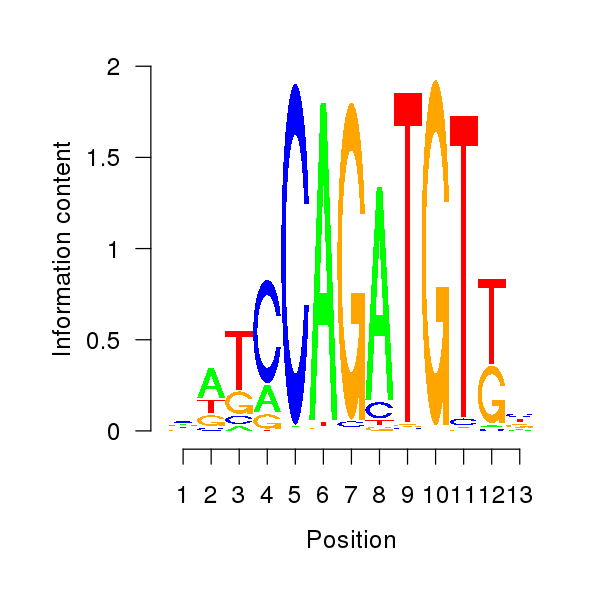

In [14]:
#sequence logo for ZBTB18
mx <- toPWM(Matrix(jaspar_2020)$ZBTB18, "prob" )
seqLogo::seqLogo(mx)